In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

In [12]:
url = '../data/clean/combined_data_control.txt'
df = pd.read_csv(url)

In [17]:
df.head(10)

,client_id,visitor_id,visit_id,process_step,date_time,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation
0,1028,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 19:00:26,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control
1,1028,42237450_62128060588,557292053_87239438319_391157,step_2,2017-04-08 19:00:17,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control
2,1028,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 19:00:15,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control
3,1028,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 18:59:55,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control
4,1028,42237450_62128060588,557292053_87239438319_391157,step_3,2017-04-08 18:58:04,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control
5,1028,42237450_62128060588,557292053_87239438319_391157,step_2,2017-04-08 18:53:29,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control
6,1028,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 18:53:20,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control
7,1028,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 18:52:17,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control
8,1028,42237450_62128060588,557292053_87239438319_391157,start,2017-04-08 18:51:28,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control
9,1104,194240915_18158000533,543158812_46395476577_767725,start,2017-06-12 07:49:18,5.0,66.0,48.0,U,3.0,154643.94,6.0,9.0,Control


In [22]:
df['date_time'] = pd.to_datetime(df['date_time'])

# Sort by client_id and date_time to ensure the steps are in chronological order
df = df.sort_values(by=['client_id', 'date_time'])

# Define the process steps in the correct order
process_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Create a new column that shows the next step
df['next_step'] = df.groupby('client_id')['process_step'].shift(-1)

# Create a column to identify "step back" (where the next step is lower in the process order)
df['is_step_back'] = df.apply(lambda row: process_order.index(row['next_step']) < process_order.index(row['process_step']) 
                              if pd.notnull(row['next_step']) else False, axis=1)

# Count the number of "step back" errors
step_back_errors = df['is_step_back'].sum()

# Display the rows with step back errors
step_back_rows = df[df['is_step_back'] == True]

print(f"Number of step back errors: {step_back_errors}")

Number of step back errors: 13297


In [28]:
# Step 1: Filter and get the last 'start' and 'confirm' time for each client
start_df = df[df['process_step'] == 'start'].sort_values('date_time').groupby('client_id').tail(1)[['client_id', 'date_time']].rename(columns={'date_time': 'start_time'})
confirm_df = df[df['process_step'] == 'confirm'].sort_values('date_time').groupby('client_id').tail(1)[['client_id', 'date_time']].rename(columns={'date_time': 'confirm_time'})

# Step 2: Merge the two DataFrames on client_id
merged_df = pd.merge(start_df, confirm_df, on='client_id', how='left')  # use 'left' to keep all clients with 'start' step

# Step 3: Calculate the process time (confirm_time - start_time) in minutes
merged_df['process_duration'] = (merged_df['confirm_time'] - merged_df['start_time']).dt.total_seconds() / 60  # Convert to minutes

# Step 4: Handle customers who did not finish the process (no 'confirm' step)
# Customers without a confirm step will have NaN in 'process_duration'
merged_df['process_duration'] = merged_df['process_duration'].fillna('Not Completed')  # Or use any other placeholder for missing process durations

# Show the result with process duration for each client
merged_df[['client_id', 'start_time', 'confirm_time', 'process_duration']]

,client_id,start_time,confirm_time,process_duration
0,7179755,2017-03-15 00:19:28,2017-03-15 00:26:24,6.933333
1,9584408,2017-03-15 06:14:28,2017-03-15 06:16:08,1.666667
2,4856478,2017-03-15 07:54:41,2017-03-15 08:02:22,7.683333
3,8957145,2017-03-15 10:07:43,NaT,Not Completed
4,8463143,2017-03-15 11:05:48,2017-03-15 11:09:45,3.95
...,...,...,...,...
23386,8087297,2017-06-20 22:25:14,2017-06-20 22:31:10,5.933333
23387,1104,2017-06-20 22:31:33,NaT,Not Completed
23388,1558312,2017-06-20 23:16:46,2017-06-20 23:26:00,9.233333
23389,291330,2017-06-20 23:21:34,NaT,Not Completed


In [32]:
df.columns

Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time',
       'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts',
       'bal', 'calls_6_mnth', 'logons_6_mnth', 'Variation', 'next_step',
       'is_step_back'],
      dtype='object')

In [35]:
df.columns = ['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time',
       'tenure_year', 'tenure_month', 'age', 'gender', 'num_accounts',
       'balance', 'calls_6_months', 'logons_6_months', 'variation', 'next_step',
       'is_step_back']
df.columns

Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time',
       'tenure_year', 'tenure_month', 'age', 'gender', 'num_accounts',
       'balance', 'calls_6_months', 'logons_6_months', 'variation',
       'next_step', 'is_step_back'],
      dtype='object')

In [42]:
df.describe()

,client_id,date_time,tenure_year,tenure_month,age,num_accounts,balance,calls_6_months,logons_6_months
count,1.404820e+05,140482,140482.000000,140482.000000,140482.000000,140482.000000,1.404820e+05,140482.000000,140482.000000
mean,5.013519e+06,2017-04-22 01:32:30.444185088,12.167794,152.005915,48.284478,2.272676,1.588905e+05,3.267693,6.303555
min,1.028000e+03,2017-03-15 00:19:28,2.000000,33.000000,17.000000,2.000000,2.378961e+04,0.000000,3.000000
25%,2.526422e+06,2017-04-05 11:13:07.500000,6.000000,82.000000,34.500000,2.000000,4.109078e+04,1.000000,4.000000
50%,5.033441e+06,2017-04-12 17:56:02.500000,11.000000,137.000000,49.500000,2.000000,6.883551e+04,3.000000,6.000000
75%,7.468037e+06,2017-05-08 13:27:59.500000,16.000000,193.000000,60.500000,2.000000,1.493742e+05,6.000000,9.000000
max,9.998921e+06,2017-06-20 23:57:06,55.000000,669.000000,96.000000,7.000000,8.292996e+06,6.000000,9.000000
std,2.865925e+06,NaN,6.980923,83.405945,15.620775,0.551134,3.026905e+05,2.184396,2.171217


In [45]:
df.select_dtypes("object").columns
# 6 columns no numerical 

Index(['visitor_id', 'visit_id', 'process_step', 'gender', 'variation',
       'next_step'],
      dtype='object')

In [48]:
df.isnull().sum().sort_values(ascending=False)
# We only have missing values in Next_step 

next_step          23526
client_id              0
visitor_id             0
visit_id               0
process_step           0
date_time              0
tenure_year            0
tenure_month           0
age                    0
gender                 0
num_accounts           0
balance                0
calls_6_months         0
logons_6_months        0
variation              0
is_step_back           0
dtype: int64

In [51]:
# Frequency table
frequency_table = df['process_step'].value_counts()

# Calculating the proportion of each unique value
proportion_table = df['process_step'].value_counts(normalize=True)

frequency_table, proportion_table

(process_step
 start      45361
 step_1     29533
 step_2     25764
 step_3     22495
 confirm    17329
 Name: count, dtype: int64,
 process_step
 start      0.322895
 step_1     0.210226
 step_2     0.183397
 step_3     0.160127
 confirm    0.123354
 Name: proportion, dtype: float64)

In [59]:
my_table = pd.crosstab(index = df["process_step"],  # Make a crosstab
                              columns="count")      # Name the count column
my_table
(my_table/my_table.sum()).round(2)

col_0,count
process_step,
confirm,0.12
start,0.32
step_1,0.21
step_2,0.18
step_3,0.16


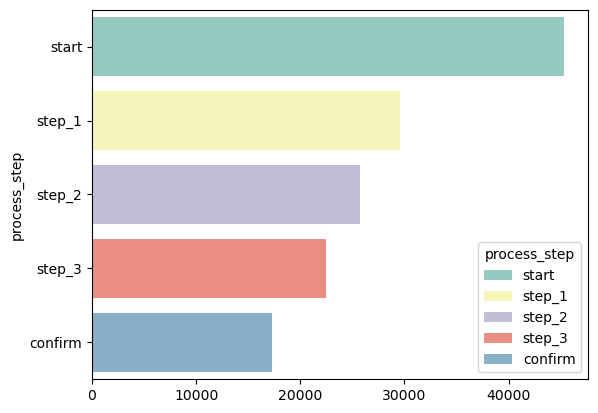

In [62]:
ax=sns.barplot(y=frequency_table.index, x=frequency_table.values, palette="Set3", hue=frequency_table.index, legend='full')
sns.move_legend(ax, "lower right")

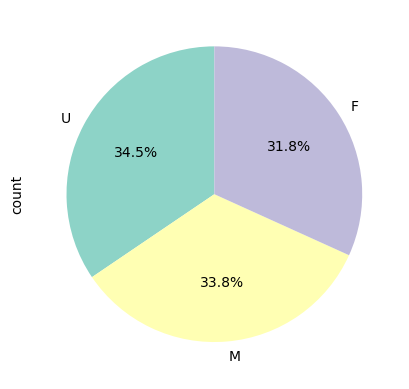

In [67]:
df['gender'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"));
# U means Unknown

In [71]:
# Measures of centrality of the column balance: 
mean_balance = df['balance'].mean()
median_balance = df['balance'].median()
mode_balance = df['balance'].mode()[0]
print(mean_balance)
print(median_balance)
print(mode_balance)

158890.54829750428
68835.51
62433.619999999995


In [75]:
# Measures of dispersion of the column balance: 
variance_balance = df['balance'].var()
std_dev_balance = df['balance'].std()
min_balance = df['balance'].min()
max_balance = df['balance'].max()
range_balance = max_balance - min_balance
quantiles_balance = df['balance'].quantile([0.25, 0.5, 0.75])
print(variance_balance)
print(std_dev_balance)
print(min_balance)
print(max_balance)
print(range_balance)
print(quantiles_balance)

91621565884.09766
302690.54475503135
23789.609999999997
8292996.21
8269206.6
0.25     41090.78
0.50     68835.51
0.75    149374.24
Name: balance, dtype: float64


In [78]:
skewness_price = df['balance'].skew()
kurtosis_price = df['balance'].kurtosis()
print(skewness_price)
print(kurtosis_price)

8.022040047731588
110.02096331198679


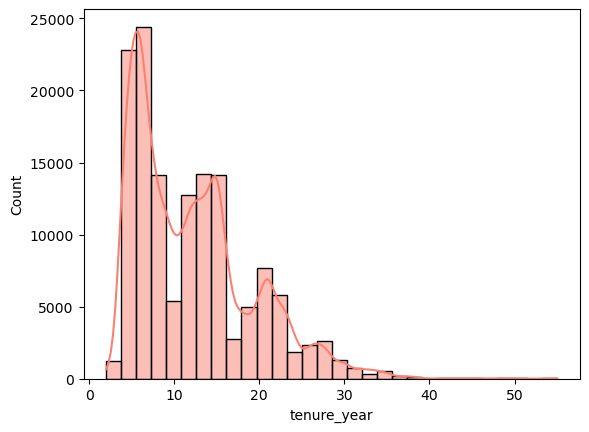

In [82]:
sns.histplot(df['tenure_year'], kde=True, bins=30, color="salmon");

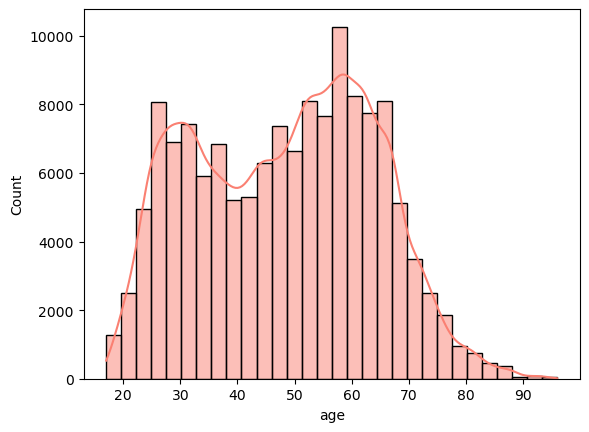

In [86]:
sns.histplot(df['age'], kde=True, bins=30, color="salmon");

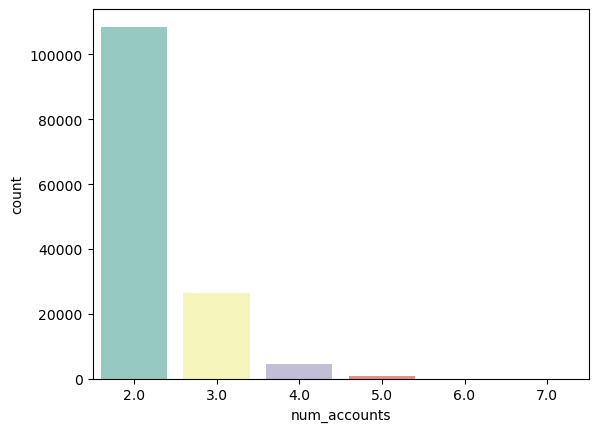

In [89]:
sns.countplot(data=df, x='num_accounts', palette="Set3", hue='num_accounts', legend=False);

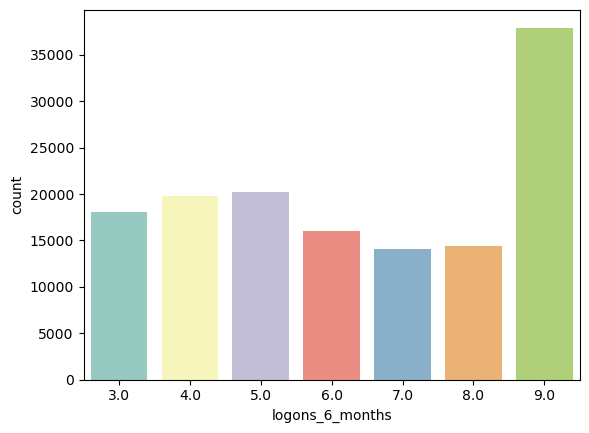

In [93]:
sns.countplot(data=df, x='logons_6_months', palette="Set3", hue='logons_6_months', legend=False);

In [112]:
bins = [0, 100000, 200000, 300000,df['balance'].max()]
labels = ['Low', 'Medium', 'High', 'Very High']
df['balance_category'] = pd.cut(df['balance'], bins=bins, labels=labels, include_lowest=True)
df.balance_category.value_counts()

balance_category
Low          89004
Medium       25305
Very High    16973
High          9200
Name: count, dtype: int64

In [114]:
df['balance_quantile'] = pd.qcut(df['balance'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
df.balance_quantile.value_counts()

balance_quantile
Q3    35128
Q1    35125
Q2    35118
Q4    35111
Name: count, dtype: int64

In [118]:
df_filtered = df[df['balance_quantile'] != 'Q4']

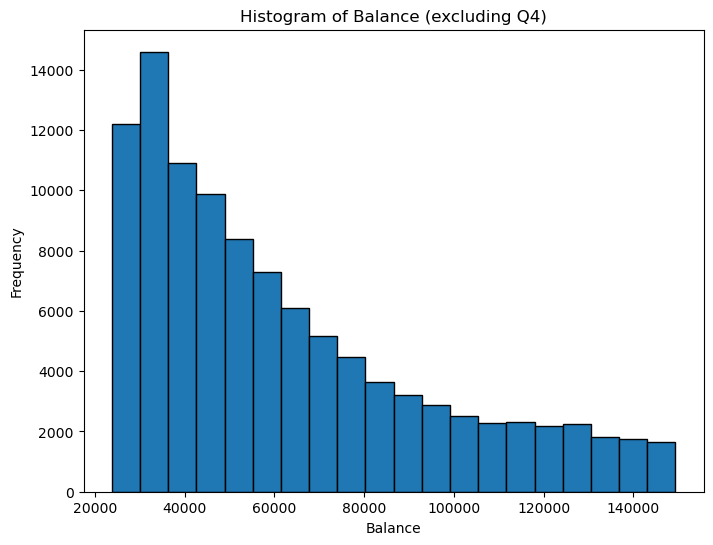

In [123]:
plt.figure(figsize=(8, 6))
plt.hist(df_filtered['balance'], bins=20, edgecolor='black')
plt.title('Histogram of Balance (excluding Q4)')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()

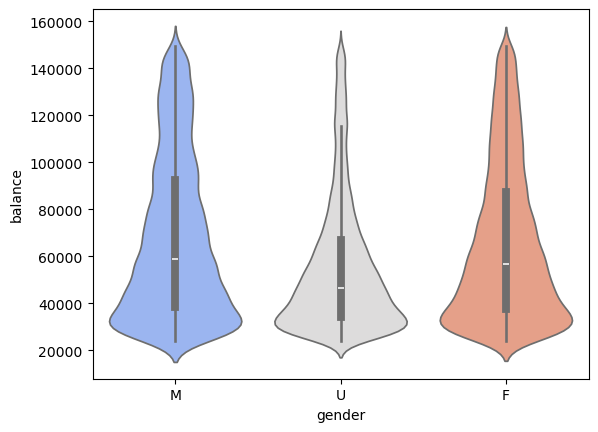

In [126]:
sns.violinplot(data=df_filtered, x='gender', y='balance', palette="coolwarm", hue='gender', legend=False);

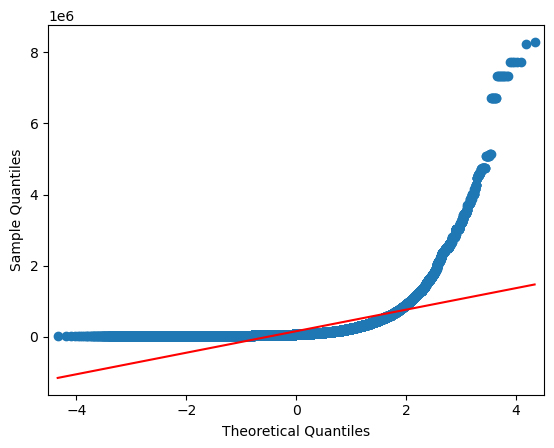

In [130]:
sm.qqplot(df['balance'], line='s');

In [137]:
# Convert the 'timestamp' column to datetime
df['date_time'] = pd.to_datetime(df['date_time'])
df['date_time']

8        2017-04-08 18:51:28
7        2017-04-08 18:52:17
6        2017-04-08 18:53:20
5        2017-04-08 18:53:29
4        2017-04-08 18:58:04
                 ...        
140473   2017-03-29 15:30:11
140472   2017-03-29 15:30:25
140470   2017-03-29 15:37:28
140471   2017-03-29 15:37:28
140481   2017-04-18 11:26:31
Name: date_time, Length: 140482, dtype: datetime64[ns]

In [141]:
# Sort by user_id and timestamp
df = df.sort_values(by=['client_id',"visitor_id", "visit_id",'date_time'])
df

,client_id,visitor_id,visit_id,process_step,date_time,tenure_year,tenure_month,age,gender,num_accounts,balance,calls_6_months,logons_6_months,variation,next_step,is_step_back,balance_category,balance_quantile
8,1028,42237450_62128060588,557292053_87239438319_391157,start,2017-04-08 18:51:28,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control,step_1,False,Medium,Q3
7,1028,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 18:52:17,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control,step_1,False,Medium,Q3
6,1028,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 18:53:20,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control,step_2,False,Medium,Q3
5,1028,42237450_62128060588,557292053_87239438319_391157,step_2,2017-04-08 18:53:29,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control,step_3,False,Medium,Q3
4,1028,42237450_62128060588,557292053_87239438319_391157,step_3,2017-04-08 18:58:04,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control,step_1,True,Medium,Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140473,9998346,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:30:11,50.0,602.0,61.5,F,2.0,149881.38,6.0,9.0,Control,step_3,False,Medium,Q4
140472,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:30:25,50.0,602.0,61.5,F,2.0,149881.38,6.0,9.0,Control,step_3,False,Medium,Q4
140470,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:37:28,50.0,602.0,61.5,F,2.0,149881.38,6.0,9.0,Control,confirm,False,Medium,Q4
140471,9998346,292425655_16607136645,189177304_69869411700_783154,confirm,2017-03-29 15:37:28,50.0,602.0,61.5,F,2.0,149881.38,6.0,9.0,Control,NaN,False,Medium,Q4


In [144]:
# Calculate the time difference between consecutive steps for each user
df['time_diff'] = df.groupby(['client_id', 'visitor_id', 'visit_id'])['date_time'].diff()
df['time_diff']

8                    NaT
7        0 days 00:00:49
6        0 days 00:01:03
5        0 days 00:00:09
4        0 days 00:04:35
               ...      
140473   0 days 00:00:16
140472   0 days 00:00:14
140470   0 days 00:07:03
140471   0 days 00:00:00
140481               NaT
Name: time_diff, Length: 140482, dtype: timedelta64[ns]

In [147]:
# Now calculate the total time spent for each user by summing up the time differences
# If you want total time in seconds or minutes:
df['time_diff_seconds'] = df['time_diff'].dt.total_seconds()
df['time_diff_seconds']

8           NaN
7          49.0
6          63.0
5           9.0
4         275.0
          ...  
140473     16.0
140472     14.0
140470    423.0
140471      0.0
140481      NaN
Name: time_diff_seconds, Length: 140482, dtype: float64

In [150]:
# Calculate the total time per user (sum of time differences in seconds)
total_time_per_user_seconds = df.groupby(['client_id', "visitor_id", "visit_id"])['time_diff_seconds'].sum()
total_time_per_user_seconds

client_id  visitor_id             visit_id                    
1028       42237450_62128060588   557292053_87239438319_391157     538.0
1104       194240915_18158000533  543158812_46395476577_767725       0.0
                                  643221571_99977972121_69283        0.0
1186       446844663_31615102958  507052512_11309370126_442139       0.0
                                  795373564_99931517312_810896      22.0
                                                                   ...  
9997470    395791369_55562604618  761490147_96352537762_21814     2626.0
                                  904791598_9725982898_416914        0.0
           91394485_75296404278   655572400_94971272893_411965       0.0
9998346    292425655_16607136645  189177304_69869411700_783154     748.0
9998921    960034051_85687824805  378424178_59565976155_8051         0.0
Name: time_diff_seconds, Length: 32235, dtype: float64

In [153]:
# Convert the total time from seconds to a more readable format (e.g., minutes, hours)
total_time_per_user_minutes = total_time_per_user_seconds / 60
total_time_per_user_hours = total_time_per_user_seconds / 3600
total_time_per_user_minutes

client_id  visitor_id             visit_id                    
1028       42237450_62128060588   557292053_87239438319_391157     8.966667
1104       194240915_18158000533  543158812_46395476577_767725     0.000000
                                  643221571_99977972121_69283      0.000000
1186       446844663_31615102958  507052512_11309370126_442139     0.000000
                                  795373564_99931517312_810896     0.366667
                                                                    ...    
9997470    395791369_55562604618  761490147_96352537762_21814     43.766667
                                  904791598_9725982898_416914      0.000000
           91394485_75296404278   655572400_94971272893_411965     0.000000
9998346    292425655_16607136645  189177304_69869411700_783154    12.466667
9998921    960034051_85687824805  378424178_59565976155_8051       0.000000
Name: time_diff_seconds, Length: 32235, dtype: float64

In [156]:
total_time_per_user_hours

client_id  visitor_id             visit_id                    
1028       42237450_62128060588   557292053_87239438319_391157    0.149444
1104       194240915_18158000533  543158812_46395476577_767725    0.000000
                                  643221571_99977972121_69283     0.000000
1186       446844663_31615102958  507052512_11309370126_442139    0.000000
                                  795373564_99931517312_810896    0.006111
                                                                    ...   
9997470    395791369_55562604618  761490147_96352537762_21814     0.729444
                                  904791598_9725982898_416914     0.000000
           91394485_75296404278   655572400_94971272893_411965    0.000000
9998346    292425655_16607136645  189177304_69869411700_783154    0.207778
9998921    960034051_85687824805  378424178_59565976155_8051      0.000000
Name: time_diff_seconds, Length: 32235, dtype: float64

In [159]:
total_time_per_user_seconds.mean()

280.48317046688385

In [164]:
total_time_per_user_minutes.mean()

4.674719507781396

In [167]:
total_time_per_user_hours.mean()

0.07791199179635662

In [169]:
df.columns

Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time',
       'tenure_year', 'tenure_month', 'age', 'gender', 'num_accounts',
       'balance', 'calls_6_months', 'logons_6_months', 'variation',
       'next_step', 'is_step_back', 'balance_category', 'balance_quantile',
       'time_diff', 'time_diff_seconds'],
      dtype='object')

In [177]:
# Ensure date_time is in datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Sort by client_id, visit_id, and date_time to ensure chronological order
df = df.sort_values(by=['client_id', 'visit_id', 'date_time'])

# Define the process steps in the correct order
process_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Create a new column that shows the next step
df['next_step'] = df.groupby(['client_id', 'visit_id'])['process_step'].shift(-1)

# Identify step-back errors
df['is_step_back'] = df.apply(
    lambda row: process_order.index(row['next_step']) < process_order.index(row['process_step']) 
    if pd.notnull(row['next_step']) else False, axis=1
)

# Calculate total steps and total errors
total_steps = len(df)  # Total number of rows (steps)
total_step_back_errors = df['is_step_back'].sum()  # Sum of step-back errors

# Calculate the overall error rate
total_error_rate = total_step_back_errors / total_steps * 100

print(f"Total number of steps: {total_steps}")
print(f"Total number of step-back errors: {total_step_back_errors}")
print(f"Total error rate: {total_error_rate:.6f}%")

Total number of steps: 140482
Total number of step-back errors: 9576
Total error rate: 6.816532%


In [179]:
df.columns

Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time',
       'tenure_year', 'tenure_month', 'age', 'gender', 'num_accounts',
       'balance', 'calls_6_months', 'logons_6_months', 'variation',
       'next_step', 'is_step_back', 'balance_category', 'balance_quantile',
       'time_diff', 'time_diff_seconds'],
      dtype='object')

In [183]:
df.time_diff_seconds.mean()
# Mean Start - Step1
# Mean Step 1 - Step 2
# Mean Step 2- Step 3
# Mean Step 3- Confirm
# Mean Start - Confirm 

83.52540948017035

In [185]:
df

,client_id,visitor_id,visit_id,process_step,date_time,tenure_year,tenure_month,age,gender,num_accounts,balance,calls_6_months,logons_6_months,variation,next_step,is_step_back,balance_category,balance_quantile,time_diff,time_diff_seconds
8,1028,42237450_62128060588,557292053_87239438319_391157,start,2017-04-08 18:51:28,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control,step_1,False,Medium,Q3,NaT,NaN
7,1028,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 18:52:17,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control,step_1,False,Medium,Q3,0 days 00:00:49,49.0
6,1028,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 18:53:20,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control,step_2,False,Medium,Q3,0 days 00:01:03,63.0
5,1028,42237450_62128060588,557292053_87239438319_391157,step_2,2017-04-08 18:53:29,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control,step_3,False,Medium,Q3,0 days 00:00:09,9.0
4,1028,42237450_62128060588,557292053_87239438319_391157,step_3,2017-04-08 18:58:04,12.0,145.0,36.0,M,3.0,103520.22,1.0,4.0,Control,step_1,True,Medium,Q3,0 days 00:04:35,275.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140473,9998346,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:30:11,50.0,602.0,61.5,F,2.0,149881.38,6.0,9.0,Control,step_3,False,Medium,Q4,0 days 00:00:16,16.0
140472,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:30:25,50.0,602.0,61.5,F,2.0,149881.38,6.0,9.0,Control,step_3,False,Medium,Q4,0 days 00:00:14,14.0
140470,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:37:28,50.0,602.0,61.5,F,2.0,149881.38,6.0,9.0,Control,confirm,False,Medium,Q4,0 days 00:07:03,423.0
140471,9998346,292425655_16607136645,189177304_69869411700_783154,confirm,2017-03-29 15:37:28,50.0,602.0,61.5,F,2.0,149881.38,6.0,9.0,Control,NaN,False,Medium,Q4,0 days 00:00:00,0.0
